In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from scipy.optimize import curve_fit
import estimation_functions as ef
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [4]:
# Define default plot parameters
# Set the default font family
plt.rcParams['font.family'] = 'Helvetica'

# Set font size for tick labels
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

# Set font size for legend
plt.rcParams['legend.fontsize'] = 24

# Set font size for guide (axis labels, titles, etc.)
plt.rcParams['axes.labelsize'] = 24

#Define the colors to match Julia plots
color_blue = '#75BDF7'
color_orange = '#E57650'

In [5]:
#Import the data
data_folder = '../data'
figures_folder = '../Figures/'
df = pd.read_csv(data_folder + '/data.csv',index_col=0,parse_dates=True)

165.00311403566656


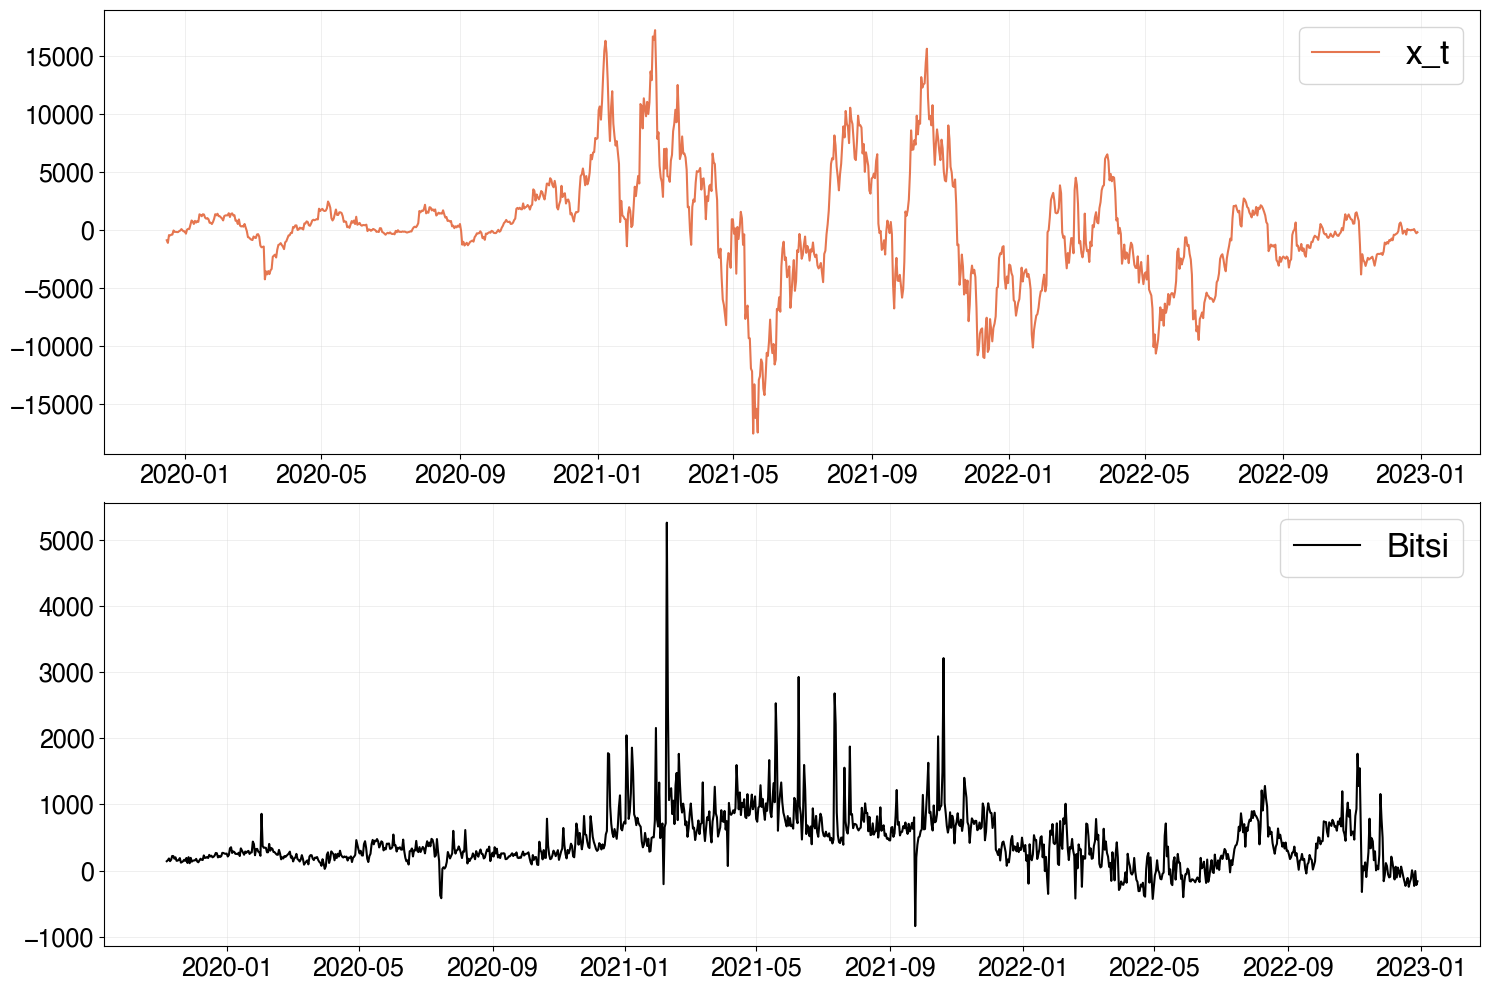

In [6]:
# Transform the BTC data in deviation from a moving average
def get_data_deviation(df, window_size, savefile = None):
    window_size = window_size #days
    df['fundamental'] = df['BTC'].rolling(window_size).mean()
    df['BTC_dev'] = (df['BTC'] - df['fundamental'])
    df['BITSI'] = df['compound']
    #df['sigma'] = np.var(df['BTC'] - df['Rf']*df['BTC'].shift(1))
    #plot the deviation and the moving average, layout (2,1)
    fig, axs = plt.subplots(2, 1, figsize=(15,10))
    axs[0].plot(df['BTC_dev'], color=color_orange, label='x_t')
    axs[1].plot(df['BITSI'], color='black', label = 'Bitsi')
    #legend
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')
    #add lightgrey lines in the background
    axs[0].grid(color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.5)
    axs[1].grid(color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.5)
    fig.tight_layout()
    if savefile != None:
        plt.savefig(figures_folder + savefile)
    

    return df

#df_raw_after  = get_data_deviation(df_after, 7, savefile='/deviation_after.png')
#df_raw_before = get_data_deviation(df_before, 7, savefile='/deviation_before.png')
df_raw = get_data_deviation(df, 40)
print(df['BTC_dev'].mean())

In [7]:
# Create the estimation data set
def create_estimation_df(df, a = 1.0):
    df_estimation = pd.DataFrame()
    #Divide each variable by 10000 to make the coefficients of the same order of magnitude
    df_estimation['fundamental'] = df['fundamental']
    df_estimation['y'] = df['BTC_dev']#/df['fundamental']
    df_estimation['x0'] = ((df['BITSI'].shift(0)))#/df['fundamental']
    df_estimation['x1'] = (df['BTC_dev'].shift(1))#/ df['fundamental']
    df_estimation['x2'] = ((df['BITSI']).shift(2))
    df_estimation['x3'] = (df['BTC_dev'].shift(3))
    df_estimation['x4'] = (df['BTC_dev'].shift(1))
    df_estimation['x5'] = (df['BTC_dev'].shift(2))
    df_estimation['x6'] = (df['Rf'])
    df_estimation['x7'] = (df['Rf'].shift(2))
    df_estimation['x8'] = a * (df['fundamental'].shift(3))**2
    df_estimation['y_ML'] = df['BTC_dev'].shift(-1)
    df_estimation = df_estimation.dropna()
    return df_estimation

df_estimation = create_estimation_df(df_raw)

# Exported the estimation data set
df_estimation.to_csv(data_folder + '/df_estimation.csv')


In [8]:
#Define the data for the LSTM
X = df_estimation[['x0','x1','x2','x3', 'x5', 'x6']].values
#sum X across the columns
y = df_estimation['y'].values

# Reshape the input data to be 3D (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

In [11]:
# Define a deep neural network
model = Sequential()

# add a dense layer with 100 neurons
model.add(LSTM(96, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [12]:
# set learning rate
model.optimizer.lr = 0.01

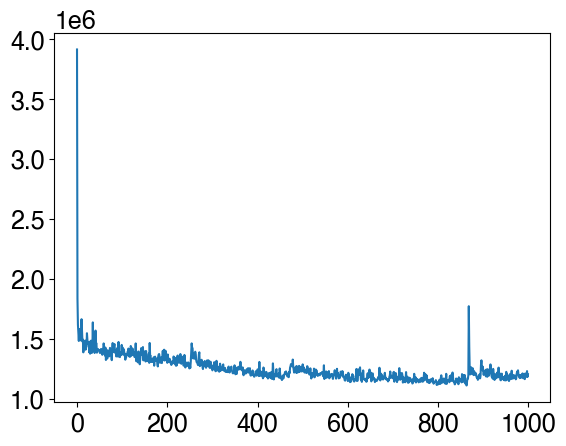

In [13]:
# Train the model
model.fit(X, y, epochs=1000, verbose=0)

# show the loss of the model
plt.plot(model.history.history['loss'], label='train')

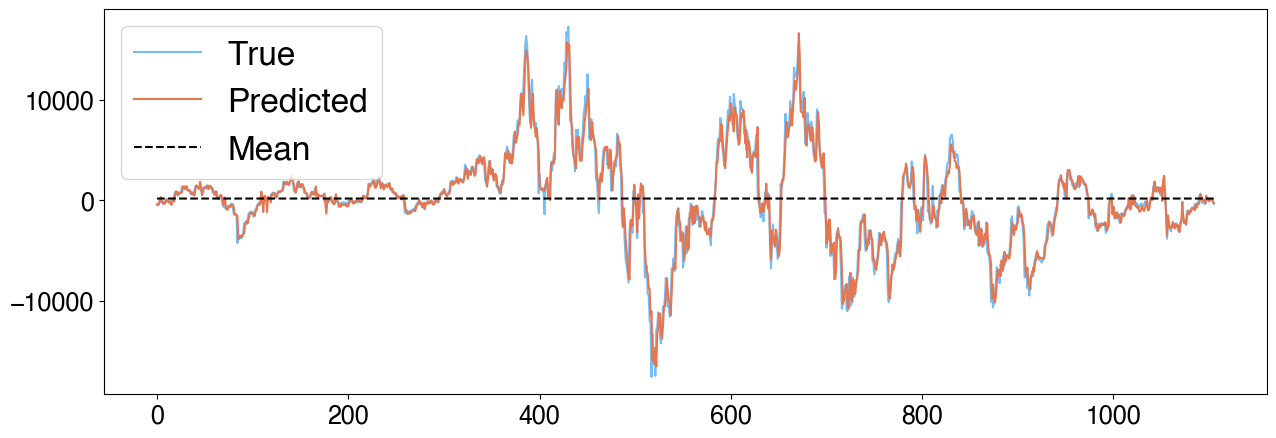

In [14]:
# Make predictions
yhat = model.predict(X, verbose=0)[:,-1]

# Plot the results
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(y, color=color_blue, label='True')
ax.plot(yhat, color=color_orange, label='Predicted')
ax.plot(y.mean()*np.ones(len(y)), color='black', linestyle='--', label='Mean')
ax.legend()
plt.show()

In [15]:
# Evaluate the r-squared
tss = np.sum((y - np.mean(y))**2)
rss = np.sum((y - yhat)**2)
r_squared = 1 - rss/tss
print(r_squared)

0.9486454608866535


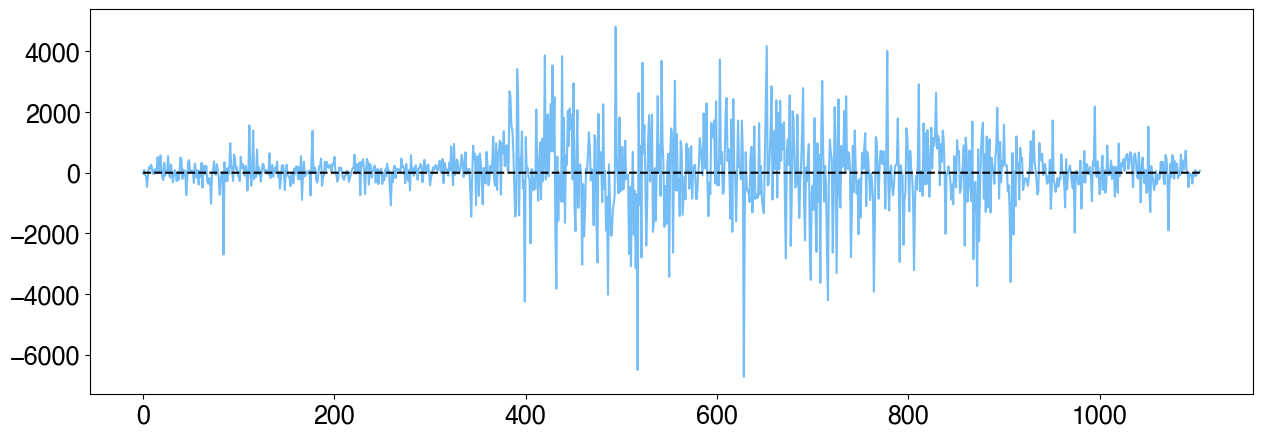

In [16]:
# plot the residuals
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(y - yhat, color=color_blue)
ax.plot(np.zeros(len(y)), color='black', linestyle='--')
plt.show()

In [17]:
# Save the estimated data
df_estimation['y'] = df_estimation['y']/df_estimation['fundamental']
df_estimation['x0'] = df_estimation['x0']/df_estimation['fundamental']
df_estimation['x1'] = df_estimation['x1']/df_estimation['fundamental']
df_estimation['x9'] = yhat/df_estimation['fundamental']
# shift by 2 yhat
df_estimation['x10']  = np.roll(yhat, 2)
df_estimation = df_estimation.dropna()
df_estimation.to_csv(data_folder + '/df_estimation.csv')

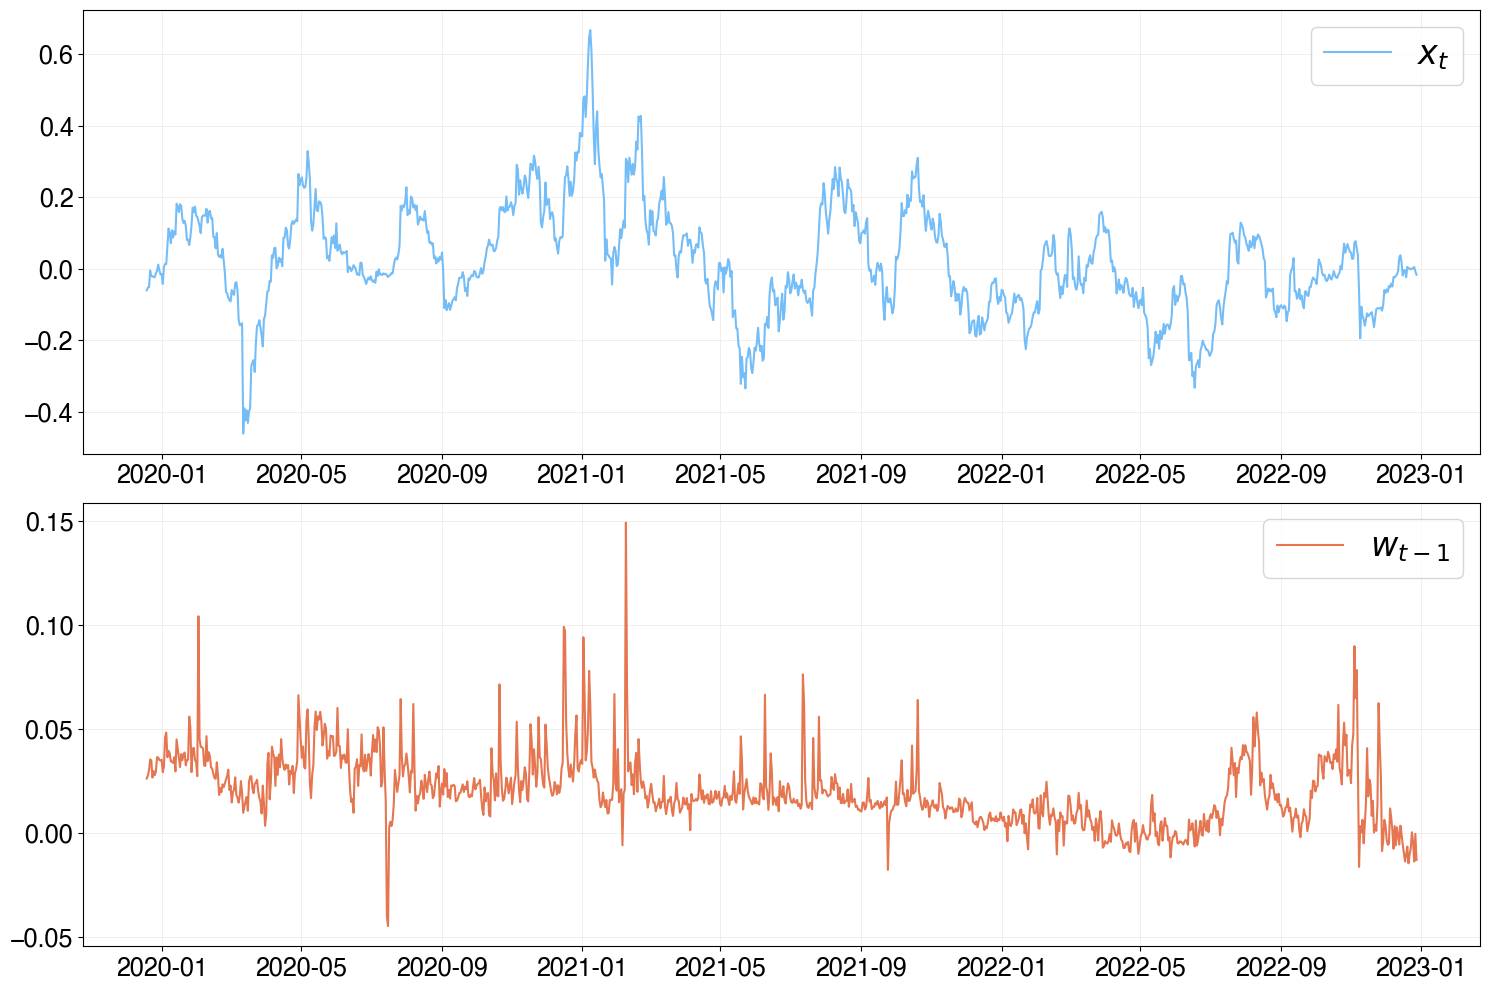

In [19]:
#plot the variables
fig, axs = plt.subplots(2, 1, figsize=(15,10))
axs[0].plot(df_estimation['y'], color=color_blue, label=r'$x_t$')
axs[1].plot(df_estimation['x0'], color=color_orange, label=r'$w_{t-1}$')

#legend
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

#add lightgrey lines in the background
axs[0].grid(color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.5)
axs[1].grid(color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.5)
fig.tight_layout()


# save the figure
plt.savefig(figures_folder + '/estimation_variables.png', dpi=300)
plt.show()

In [114]:
# Test for stationarity
adf_y = adfuller(df_estimation['y'])
adf_Bitsi = adfuller(df_estimation['x0'])
# print the p-value 
print(adf_y[1], adf_Bitsi[1])

1.271598162586702e-06 0.03760189542086754
